In [100]:
import os
import torch
import torchvision
import PIL.Image as Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [75]:
os.listdir('C:/Users/eloy/Downloads/pajaros2/birds/birds')


['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'AVADAVAT',
 'AZURE JAY',
 'AZURE TANAGER',
 'AZURE TIT',
 'BAIKAL TEAL',
 'BALD EAGLE',
 'BALD IBIS',
 'BALI STARLING',
 'BALTIMORE ORIOLE',
 'BANANAQUIT',
 'BAND TAILED GUAN',
 'BANDED BROADBILL',
 'BANDED PITA',
 'BANDED STILT',
 'BAR-TAILED GODWIT',
 'BARN OWL',
 'BARN SWALLOW',
 'BARRED PUFFBIRD',
 'BARROWS GOLDENEYE',
 'BAY-B

In [76]:
train_dataset_path = 'C:/Users/eloy/Downloads/pajaros2/birds/birds'
test_dataset_path = 'C:/Users/eloy/Downloads/pajaros2/birds/birdsTest'



In [77]:
mean = [0.4704, 0.4669, 0.3898]
std = [0.2037, 0.2002, 0.2051]

train_transforms = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(10),
                                        transforms.ToTensor(),
                                        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])

test_transforms = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])

In [78]:
train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path, transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root= test_dataset_path, transform=test_transforms)
print(len(train_dataset))
print(len(test_dataset))

48788
9623


In [79]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid (images, nrow = 3)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([147, 349, 321, 174,  66, 110])


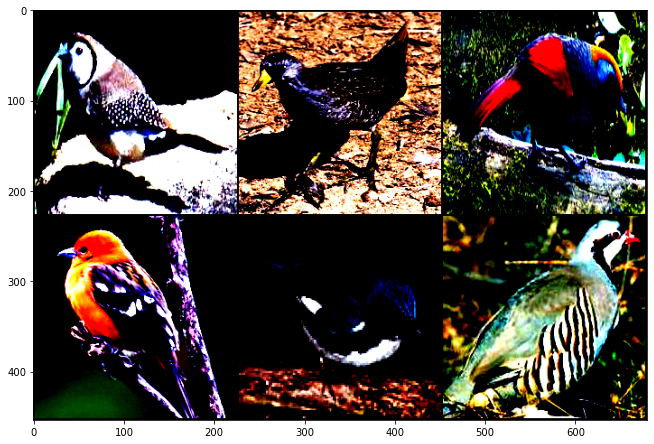

In [80]:
show_transformed_images(test_dataset)

In [81]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)


In [82]:
def set_device():
    if torch.cuda.is_available():
        dev = 'cuda:0'
    else:
        dev = 'cpu'
    return torch.device(dev)

In [83]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    
    best_acc = 0
    for epoch in range(n_epochs):
        print("Epoch number %d" % (epoch +1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0 
        total = 0
        
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_correct +=(labels==predicted).sum().item()
            
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 *running_correct / total
        
        print('-Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f'
             % (running_correct, total, epoch_acc, epoch_loss))
        
        test_dataset_acc = evaluate_model_on_test_set(model, test_loader)
        
        if(test_dataset_acc > best_acc):
            best_acc = test_dataset_acc
            save_checkpoint(model, epoch, optimizer, best_acc)

            
        
    print("Finished")

    return model
        
            

In [84]:
def evaluate_model_on_test_set(model, test_loader):
        model.eval()
        predicted_correctly_on_epoch = 0
        total = 0
        device = set_device()
        
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                total += labels.size(0)

                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)

                predicted_correctly_on_epoch += (predicted == labels).sum().item()

        epoch_acc = 100.00 *predicted_correctly_on_epoch / total
        print('-Testing dataset. Got %d out of %d images correctly (%.3f%%)'
             % (predicted_correctly_on_epoch, total, epoch_acc))
        return epoch_acc

In [85]:
def save_checkpoint(model,epoch, optimizer, best_acc):
    state = {
        'epoch':epoch +1,
        'model': model.state_dict(),
        'best accuracy': best_acc,
        'optimizer' : optimizer.state_dict(),
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [86]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained = True)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 400
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr = 0.01, momentum=0.9, weight_decay=0.003)

In [87]:
train_nn(resnet18_model,train_loader, test_loader, loss_fn, optimizer, 6)

Epoch number 1
-Training dataset. Got 32179 out of 48788 images correctly (65.957%). Epoch loss: 1.671
-Testing dataset. Got 7597 out of 9623 images correctly (78.946%)
Epoch number 2
-Training dataset. Got 40251 out of 48788 images correctly (82.502%). Epoch loss: 0.887
-Testing dataset. Got 7151 out of 9623 images correctly (74.312%)
Epoch number 3
-Training dataset. Got 39882 out of 48788 images correctly (81.746%). Epoch loss: 0.935
-Testing dataset. Got 6851 out of 9623 images correctly (71.194%)
Epoch number 4
-Training dataset. Got 39578 out of 48788 images correctly (81.122%). Epoch loss: 0.956
-Testing dataset. Got 7358 out of 9623 images correctly (76.463%)
Epoch number 5
-Training dataset. Got 39617 out of 48788 images correctly (81.202%). Epoch loss: 0.954
-Testing dataset. Got 6984 out of 9623 images correctly (72.576%)
Epoch number 6
-Training dataset. Got 39697 out of 48788 images correctly (81.366%). Epoch loss: 0.944
-Testing dataset. Got 7236 out of 9623 images correc

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [88]:
checkpoint = torch.load('model_best_checkpoint.pth.tar')

In [89]:
print(checkpoint['epoch'])
print(checkpoint['best accuracy'])

1
78.94627455055596


In [90]:
resnet18_model = models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 400
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet18_model.load_state_dict(checkpoint['model'])

torch.save(resnet18_model, 'best_model.pth')

In [91]:
model = torch.load('best_model.pth')

In [92]:
classes = os.listdir('C:/Users/eloy/Downloads/pajaros2/birds/birds')


In [93]:
os.listdir('C:/Users/eloy/Downloads/pajaros2/birds/birds/ALBATROSS')

['025.jpg',
 '026.jpg',
 '027.jpg',
 '028.jpg',
 '029.jpg',
 '030.jpg',
 '031.jpg',
 '032.jpg',
 '033.jpg',
 '034.jpg',
 '035.jpg',
 '036.jpg',
 '037.jpg',
 '038.jpg',
 '039.jpg',
 '040.jpg',
 '041.jpg',
 '042.jpg',
 '043.jpg',
 '044.jpg',
 '045.jpg',
 '046.jpg',
 '047.jpg',
 '048.jpg',
 '049.jpg',
 '050.jpg',
 '051.jpg',
 '052.jpg',
 '053.jpg',
 '054.jpg',
 '055.jpg',
 '056.jpg',
 '057.jpg',
 '058.jpg',
 '059.jpg',
 '060.jpg',
 '061.jpg',
 '062.jpg',
 '063.jpg',
 '064.jpg',
 '065.jpg',
 '066.jpg',
 '067.jpg',
 '068.jpg',
 '069.jpg',
 '070.jpg',
 '071.jpg',
 '072.jpg',
 '073.jpg',
 '074.jpg',
 '075.jpg',
 '076.jpg',
 '077.jpg',
 '078.jpg',
 '079.jpg',
 '080.jpg',
 '081.jpg',
 '082.jpg',
 '083.jpg',
 '084.jpg',
 '085.jpg',
 '086.jpg',
 '087.jpg',
 '088.jpg',
 '089.jpg',
 '090.jpg',
 '091.jpg',
 '092.jpg',
 '093.jpg',
 '094.jpg',
 '095.jpg',
 '096.jpg',
 '097.jpg',
 '098.jpg',
 '099.jpg',
 '100.jpg',
 '101.jpg',
 '102.jpg',
 '103.jpg',
 '104.jpg',
 '105.jpg',
 '106.jpg',
 '107.jpg',
 '10

In [94]:
mean = [0.4704, 0.4669, 0.3898]
std = [0.2037, 0.2002, 0.2051]

image_transforms = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])

In [135]:
def classify(model, image_transforms, image_path, classes):
    model = model.eval()
    image = Image.open(image_path)
    image = image_transforms(image).float()
    image = image.unsqueeze(0)
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    print(classes[predicted.item()])


In [96]:
classify(model, image_transforms, 'C:/Users/eloy/Downloads/pajaros2/birds/birds/ALBATROSS/076.jpg' ,classes)

SNOWY OWL


In [101]:
a = os.listdir('C:/Users/eloy/Downloads/pajaros2/submission_test/submission_test')
print(len(a))
print (a)


2000
['10001367.jpg', '10011345.jpg', '10021061.jpg', '1002913.jpg', '1003410.jpg', '1003513.jpg', '1003772.jpg', '10041854.jpg', '10049.jpg', '1007716.jpg', '1007758.jpg', '10081125.jpg', '1009818.jpg', '10111097.jpg', '101212.jpg', '10121591.jpg', '1013471.jpg', '10141670.jpg', '10151201.jpg', '10171697.jpg', '101738.jpg', '1018542.jpg', '1019567.jpg', '10211583.jpg', '1021614.jpg', '10241391.jpg', '102422.jpg', '1025537.jpg', '10261025.jpg', '1026308.jpg', '102789.jpg', '1028438.jpg', '1029340.jpg', '1029726.jpg', '10301798.jpg', '1030605.jpg', '10321463.jpg', '1033986.jpg', '1036189.jpg', '10361947.jpg', '10371462.jpg', '103765.jpg', '10411320.jpg', '10411836.jpg', '10411902.jpg', '1041364.jpg', '1041633.jpg', '1041643.jpg', '1042198.jpg', '1043610.jpg', '10451857.jpg', '10461892.jpg', '10471444.jpg', '10471919.jpg', '10481559.jpg', '10481872.jpg', '10491101.jpg', '1049136.jpg', '1050525.jpg', '10511131.jpg', '10511867.jpg', '10511953.jpg', '1052505.jpg', '1053421.jpg', '1055538.jp

a = os.listdir('C:/Users/eloy/Downloads/pajaros2/birds/birds/ALBATROSS')
print(len(a))



for i in a:
    print
    classify(model, image_transforms, 'C:/Users/eloy/Downloads/pajaros2/birds/birds/ALBATROSS/'+i ,classes)


In [136]:
a = os.listdir('C:/Users/eloy/Downloads/pajaros2/birds/birds/WHITE TAILED TROPIC') 
print(len(a))

for i in a:
    print(i)
    classify(model, image_transforms, 'C:/Users/eloy/Downloads/pajaros2/birds/birds/WHITE TAILED TROPIC/'+i ,classes)

151
025.jpg
WHITE TAILED TROPIC
026.jpg
BALD EAGLE
027.jpg
WHITE TAILED TROPIC
028.jpg
WHITE TAILED TROPIC
029.jpg
WHITE TAILED TROPIC
030.jpg
ABBOTTS BOOBY
031.jpg
BROWN CREPPER
032.jpg
CRESTED KINGFISHER
033.jpg
WHITE TAILED TROPIC
034.jpg
SNOWY OWL
035.jpg
WHITE TAILED TROPIC
036.jpg
WHITE TAILED TROPIC
037.jpg
WHITE TAILED TROPIC
038.jpg
WHITE TAILED TROPIC
039.jpg
WHITE TAILED TROPIC
040.jpg
WHITE TAILED TROPIC
041.jpg
WHITE TAILED TROPIC
042.jpg
WHITE TAILED TROPIC
043.jpg
WHITE TAILED TROPIC
044.jpg
WHITE TAILED TROPIC
045.jpg
WHITE TAILED TROPIC
046.jpg
WHITE TAILED TROPIC
047.jpg
WHITE TAILED TROPIC
048.jpg
WHITE TAILED TROPIC
049.jpg
WHITE TAILED TROPIC
050.jpg
WHITE TAILED TROPIC
051.jpg
WHITE TAILED TROPIC
052.jpg
WHITE TAILED TROPIC
053.jpg
WHITE TAILED TROPIC
054.jpg
WHITE TAILED TROPIC
055.jpg
WHITE TAILED TROPIC
056.jpg
WHITE TAILED TROPIC
057.jpg
WHITE TAILED TROPIC
058.jpg
WHITE TAILED TROPIC
059.jpg
WHITE TAILED TROPIC
060.jpg
BLACK SKIMMER
061.jpg
WHITE TAILED TROPI

In [143]:
def classify(model, image_transforms, image_path, classes):
    model = model.eval()
    image = Image.open(image_path)
    image = image_transforms(image).float()
    image = image.unsqueeze(0)
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    return classes[predicted.item()]

In [144]:
a = os.listdir('C:/Users/eloy/Downloads/pajaros2/submission_test/submission_test')
print(len(a))
a.sort(key=len)
print(a)

2000
['391.jpg', '761.jpg', '1311.jpg', '1425.jpg', '1462.jpg', '1587.jpg', '3293.jpg', '3576.jpg', '4746.jpg', '5122.jpg', '6529.jpg', '7485.jpg', '8828.jpg', '9104.jpg', '9911.jpg', '9991.jpg', '10049.jpg', '11849.jpg', '12227.jpg', '12672.jpg', '12751.jpg', '12992.jpg', '13137.jpg', '13815.jpg', '14884.jpg', '14900.jpg', '15596.jpg', '16494.jpg', '16657.jpg', '17967.jpg', '18068.jpg', '18581.jpg', '18890.jpg', '20483.jpg', '20554.jpg', '20666.jpg', '21490.jpg', '24828.jpg', '25653.jpg', '27463.jpg', '28017.jpg', '28135.jpg', '28397.jpg', '29628.jpg', '30969.jpg', '34293.jpg', '35577.jpg', '35712.jpg', '38676.jpg', '39606.jpg', '39788.jpg', '40794.jpg', '43142.jpg', '44422.jpg', '45499.jpg', '46413.jpg', '48914.jpg', '52397.jpg', '52847.jpg', '53059.jpg', '56545.jpg', '57790.jpg', '60339.jpg', '61465.jpg', '61571.jpg', '61578.jpg', '62808.jpg', '64101.jpg', '66619.jpg', '67811.jpg', '71110.jpg', '71200.jpg', '71685.jpg', '71786.jpg', '72428.jpg', '72741.jpg', '73343.jpg', '74365.jpg'

In [145]:
import pandas as pd
import numpy as np
x = 'Id , Category'
lista_Indice=[]
lista_Category=[]

print(x)
for i in a:
    l = i.split('.')[0]
    lista_Indice.append(l)
    lista_Category.append(classify(model, image_transforms, 'C:/Users/eloy/Downloads/pajaros2/submission_test/submission_test/'+i ,classes))



Id , Category


In [159]:
array_de =np.array([lista_Indice,lista_Category])
array_de2 =np.transpose(array_de)
print(array_de)
matriz = pd.DataFrame(data=array_de2 , columns=['Id','Category'])
matriz

[['391' '761' '1311' ... '19981965' '19991139' '19991200']
 ['ABBOTTS BABBLER' 'CRAB PLOVER' 'TURKEY VULTURE' ...
  'WHITE THROATED BEE EATER' 'IBERIAN MAGPIE' 'JANDAYA PARAKEET']]


,Id,Category
0,391,ABBOTTS BABBLER
1,761,CRAB PLOVER
2,1311,TURKEY VULTURE
3,1425,AFRICAN FIREFINCH
4,1462,CAPE GLOSSY STARLING
...,...,...
1995,19951251,LAZULI BUNTING
1996,19961923,VULTURINE GUINEAFOWL
1997,19981965,WHITE THROATED BEE EATER
1998,19991139,IBERIAN MAGPIE


In [160]:
matriz.to_csv('cmatri.csv',index=False)


In [ ]:
matri.to_csv('cmatri.csv')


In [115]:
print(lista_Category)
print(lista_Indice)


['ABBOTTS BABBLER', 'CRAB PLOVER', 'TURKEY VULTURE', 'AFRICAN FIREFINCH', 'CAPE GLOSSY STARLING', 'AMERICAN PIPIT', 'ABBOTTS BABBLER', 'COCK OF THE  ROCK', 'ALEXANDRINE PARAKEET', 'ANIANIAU', 'SNOWY OWL', 'HARPY EAGLE', 'ABBOTTS BOOBY', 'AFRICAN FIREFINCH', 'GO AWAY BIRD', 'GREEN BROADBILL', 'ALEXANDRINE PARAKEET', 'FAIRY BLUEBIRD', 'BANDED PITA', 'CRESTED NUTHATCH', 'ALPINE CHOUGH', 'CINNAMON FLYCATCHER', 'ABBOTTS BOOBY', 'ENGGANO MYNA', 'FRIGATE', 'ABBOTTS BABBLER', 'BALD EAGLE', 'CARMINE BEE-EATER', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN BITTERN', 'AMERICAN BITTERN', 'AMERICAN KESTREL', 'GANG GANG COCKATOO', 'CAPPED HERON', 'COMMON STARLING', 'AMERICAN BITTERN', 'PINK ROBIN', 'EURASIAN MAGPIE', 'CRESTED CARACARA', 'AMERICAN AVOCET', 'AFRICAN CROWNED CRANE', 'BALD EAGLE', 'COMMON IORA', 'HOUSE FINCH', 'AMERICAN BITTERN', 'BLACK & YELLOW  BROADBILL', 'IWI', 'ABYSSINIAN GROUND HORNBILL', 'CRESTED OROPENDOLA', 'COMMON IORA', 'AMERICAN PIPIT', 'ELEGANT TROGON', 'ALBERTS TOWHEE', 'AFRICAN EME

In [114]:
x = 'Id , Category'
print(x)
for i in a:
    l = i.split('.')[0]
    print(l,',', end=" ")

    print(classify(model, image_transforms, 'C:/Users/eloy/Downloads/pajaros2/submission_test/submission_test/'+i ,classes))

Id , Category
391 , ABBOTTS BABBLER
761 , CRAB PLOVER
1311 , TURKEY VULTURE
1425 , AFRICAN FIREFINCH
1462 , CAPE GLOSSY STARLING
1587 , AMERICAN PIPIT
3293 , ABBOTTS BABBLER
3576 , COCK OF THE  ROCK
4746 , ALEXANDRINE PARAKEET
5122 , ANIANIAU
6529 , SNOWY OWL
7485 , HARPY EAGLE
8828 , ABBOTTS BOOBY
9104 , AFRICAN FIREFINCH
9911 , GO AWAY BIRD
9991 , GREEN BROADBILL
10049 , ALEXANDRINE PARAKEET
11849 , FAIRY BLUEBIRD
12227 , BANDED PITA
12672 , CRESTED NUTHATCH
12751 , ALPINE CHOUGH
12992 , CINNAMON FLYCATCHER
13137 , ABBOTTS BOOBY
13815 , ENGGANO MYNA
14884 , FRIGATE
14900 , ABBOTTS BABBLER
15596 , BALD EAGLE
16494 , CARMINE BEE-EATER
16657 , ALTAMIRA YELLOWTHROAT
17967 , AMERICAN BITTERN
18068 , AMERICAN BITTERN
18581 , AMERICAN KESTREL
18890 , GANG GANG COCKATOO
20483 , CAPPED HERON
20554 , COMMON STARLING
20666 , AMERICAN BITTERN
21490 , PINK ROBIN
24828 , EURASIAN MAGPIE
25653 , CRESTED CARACARA
27463 , AMERICAN AVOCET
28017 , AFRICAN CROWNED CRANE
28135 , BALD EAGLE
28397 , COMMON

486125 , ANNAS HUMMINGBIRD
487382 , BLUE THROATED TOUCANET
487769 , EASTERN BLUEBIRD
492399 , BORNEAN LEAFBIRD
493320 , BLACK TAIL CRAKE
495260 , BAY-BREASTED WARBLER
501569 , RED HEADED DUCK
501778 , SRI LANKA BLUE MAGPIE
502570 , CLARKS NUTCRACKER
507280 , BELTED KINGFISHER
510952 , GRAY CATBIRD
511722 , SHOEBILL
513545 , CHUCAO TAPACULO
521166 , INDIAN ROLLER
521892 , GANG GANG COCKATOO
523929 , GOLDEN CHLOROPHONIA
524754 , DOWNY WOODPECKER
527217 , BAND TAILED GUAN
529268 , BEARDED BARBET
529321 , BLACK TAIL CRAKE
529371 , BLUE GROUSE
530261 , GRAY CATBIRD
531636 , ROBIN
531835 , EUROPEAN TURTLE DOVE
539480 , CAPPED HERON
542958 , GRAY KINGBIRD
543123 , ANIANIAU
544457 , CANARY
553983 , GREAT POTOO
558272 , BEARDED BELLBIRD
561790 , ELEGANT TROGON
563944 , EASTERN GOLDEN WEAVER
570675 , CRESTED OROPENDOLA
571020 , GUINEAFOWL
571151 , INCA TERN
571213 , CRESTED SHRIKETIT
572742 , DOUBLE BRESTED CORMARANT
574806 , EMPEROR PENGUIN
575838 , AFRICAN FIREFINCH
577192 , BALD EAGLE
577524 

1177442 , CALIFORNIA CONDOR
1181254 , BARRED PUFFBIRD
1184495 , CASPIAN TERN
1185799 , ELLIOTS  PHEASANT
1189416 , BROWN NOODY
1191385 , NORTHERN MOCKINGBIRD
1191851 , FAIRY TERN
1194555 , CINNAMON ATTILA
1198531 , BLUE GROUSE
1200409 , GOLDEN EAGLE
1203870 , AMERICAN GOLDFINCH
1206155 , ASHY THRUSHBIRD
1206338 , BLACK VULTURE
1211500 , EMU
1212954 , GRAY CATBIRD
1217145 , APOSTLEBIRD
1217373 , BLUE GROUSE
1220160 , ASIAN CRESTED IBIS
1221689 , CRIMSON CHAT
1222104 , ANDEAN GOOSE
1228415 , BROWN NOODY
1230429 , BULWERS PHEASANT
1231001 , GREEN MAGPIE
1231401 , SNOWY EGRET
1231700 , CROWNED PIGEON
1231906 , GLOSSY IBIS
1232481 , CAPPED HERON
1233532 , CHINESE BAMBOO PARTRIDGE
1240760 , EARED PITA
1241507 , PUFFIN
1250256 , BARROWS GOLDENEYE
1251622 , REGENT BOWERBIRD
1252767 , EASTERN BLUEBIRD
1256167 , AVADAVAT
1258368 , BLUE COAU
1258611 , COMMON LOON
1259652 , CRESTED CARACARA
1260390 , DUSKY LORY
1261435 , OVENBIRD
1264393 , BORNEAN BRISTLEHEAD
1269561 , CINNAMON FLYCATCHER
1270898 

1826956 , GRAY KINGBIRD
1828475 , CAPE ROCK THRUSH
1830187 , BAIKAL TEAL
1836273 , BEARDED BELLBIRD
1836707 , CUBAN TODY
1837108 , ANDEAN GOOSE
1838126 , ANNAS HUMMINGBIRD
1838620 , CRESTED KINGFISHER
1839660 , CRESTED FIREBACK
1839752 , DOWNY WOODPECKER
1842456 , CANARY
1843701 , TASMANIAN HEN
1844869 , FLAME BOWERBIRD
1845319 , BLACK SWAN
1848563 , CINNAMON FLYCATCHER
1849434 , BUSH TURKEY
1851459 , CANARY
1852509 , CEDAR WAXWING
1852873 , EASTERN GOLDEN WEAVER
1857840 , EVENING GROSBEAK
1860547 , CHUCAO TAPACULO
1861279 , BEARDED REEDLING
1861371 , NORTHERN GANNET
1861449 , CALIFORNIA GULL
1869239 , BAR-TAILED GODWIT
1869488 , CAPUCHINBIRD
1869728 , DARK EYED JUNCO
1871276 , MAGPIE GOOSE
1872188 , BAIKAL TEAL
1872690 , CRIMSON SUNBIRD
1874667 , CRESTED KINGFISHER
1876647 , CRESTED AUKLET
1877795 , ELLIOTS  PHEASANT
1879178 , AZURE TANAGER
1882967 , GREAT GRAY OWL
1890348 , BLACK-NECKED GREBE
1891109 , ANDEAN LAPWING
1891702 , SCARLET CROWNED FRUIT DOVE
1894498 , CASPIAN TERN
1899529

6861741 , SNOWY OWL
6871692 , SANDHILL CRANE
6871695 , SATYR TRAGOPAN
6931016 , GUINEA TURACO
6971261 , LILAC ROLLER
6991681 , SAMATRAN THRUSH
7011364 , NORTHERN FLICKER
7021567 , RED FACED CORMORANT
7081680 , SAMATRAN THRUSH
7111319 , MARABOU STORK
7141846 , TIT MOUSE
7151241 , KOOKABURRA
7151597 , RED NAPED TROGON
7151855 , TOWNSENDS WARBLER
7171018 , WHITE CHEEKED TURACO
7171644 , ROCK DOVE
7181419 , PALILA
7201721 , SHOEBILL
7211010 , GROVED BILLED ANI
7221602 , RED TAILED HAWK
7231031 , PHILIPPINE EAGLE
7231717 , SCARLET TANAGER
7251409 , EMU
7251689 , SAND MARTIN
7281656 , ROYAL FLYCATCHER
7291402 , NORTHERN SHOVELER
7301630 , ROADRUNNER
7311084 , HIMALAYAN MONAL
7321030 , SNOWY OWL
7321757 , SPLENDID WREN
7341088 , HOATZIN
7351554 , RED BEARDED BEE EATER
7361207 , JAPANESE ROBIN
7401044 , HARLEQUIN DUCK
7401489 , PEREGRINE FALCON
7411639 , ROBIN
7431358 , AFRICAN FIREFINCH
7441467 , PARUS MAJOR
7451503 , RED TAILED HAWK
7471094 , HOODED MERGANSER
7471840 , BAIKAL TEAL
7491311 , 

13291550 , RED BEARDED BEE EATER
13311021 , GUINEAFOWL
13321325 , MASKED LAPWING
13341675 , RUFUOS MOTMOT
13351600 , RED TAILED HAWK
13371966 , WHITE THROATED BEE EATER
13391198 , JACK SNIPE
13401415 , ORANGE BRESTED BUNTING
13471928 , WALL CREAPER
13521174 , INDIGO BUNTING
13541029 , GURNEYS PITTA
13561007 , GREY PLOVER
13571535 , QUETZAL
13571814 , SUPERB STARLING
13601578 , RED FODY
13631958 , CRANE HAWK
13651594 , RED HONEY CREEPER
13701213 , JAVA SPARROW
13701911 , VIOLET GREEN SWALLOW
13721302 , MALLARD DUCK
13721368 , NORTHERN FULMAR
13731432 , OSTRICH
13731665 , RUDY KINGFISHER
13741534 , PYGMY KINGFISHER
13741727 , SHORT BILLED DOWITCHER
13761490 , PHILIPPINE EAGLE
13771136 , IBERIAN MAGPIE
13781003 , GREEN MAGPIE
13791304 , MALLARD DUCK
13801224 , KAKAPO
13801362 , NORTHERN FLICKER
13801991 , YELLOW CACIQUE
13821791 , AVADAVAT
13841282 , MALABAR HORNBILL
13841536 , QUETZAL
13851352 , NOISY FRIARBIRD
13871170 , INDIGO BUNTING
13881308 , MANDRIN DUCK
13881897 , VENEZUELIAN TROU

19691815 , SWINHOES PHEASANT
19721002 , GREEN MAGPIE
19761123 , HOUSE FINCH
19781000 , GREEN MAGPIE
19781252 , LAZULI BUNTING
19781377 , RED TAILED HAWK
19841783 , STEAMER DUCK
19851431 , OSTRICH
19891540 , RAINBOW LORIKEET
19931107 , BALD IBIS
19931684 , SAMATRAN THRUSH
19951113 , HORNED LARK
19951251 , LAZULI BUNTING
19961923 , VULTURINE GUINEAFOWL
19981965 , WHITE THROATED BEE EATER
19991139 , IBERIAN MAGPIE
19991200 , JANDAYA PARAKEET


In [ ]:
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        print(images.shape)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        print(images.shape)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
        
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std


In [ ]:
get_mean_and_std(train_loader)